In [1]:
# import libraries 
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

from matplotlib import patches
from matplotlib_venn import venn2, venn3
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import fdrcorrection

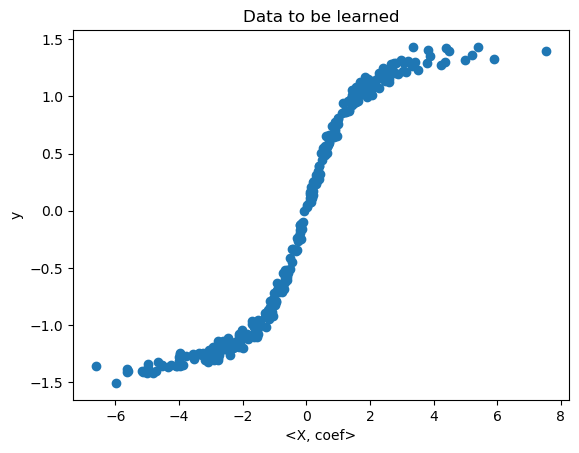

Performance of ranking  0.9787878787878788
Performance of linear regression  0.9587570621468926


In [2]:
# source: https://gist.github.com/agramfort/2071994; https://gist.github.com/fabianp/2020955

import itertools
import numpy as np

from sklearn import svm, linear_model
from sklearn.model_selection import KFold


def transform_pairwise(X, y):
    """Transforms data into pairs with balanced labels for ranking
    Transforms a n-class ranking problem into a two-class classification
    problem. Subclasses implementing particular strategies for choosing
    pairs should override this method.
    In this method, all pairs are choosen, except for those that have the
    same target value. The output is an array of balanced classes, i.e.
    there are the same number of -1 as +1
    Parameters
    ----------
    X : array, shape (n_samples, n_features)
        The data
    y : array, shape (n_samples,) or (n_samples, 2)
        Target labels. If it's a 2D array, the second column represents
        the grouping of samples, i.e., samples with different groups will
        not be considered.
    Returns
    -------
    X_trans : array, shape (k, n_feaures)
        Data as pairs
    y_trans : array, shape (k,)
        Output class labels, where classes have values {-1, +1}
    """
    X_new = []
    y_new = []
    y = np.asarray(y)
    if y.ndim == 1:
        y = np.c_[y, np.ones(y.shape[0])]
    comb = itertools.combinations(range(X.shape[0]), 2)
    for k, (i, j) in enumerate(comb):
        if y[i, 0] == y[j, 0] or y[i, 1] != y[j, 1]:
            # skip if same target or different group
            continue
        X_new.append(X[i] - X[j])
        y_new.append(np.sign(y[i, 0] - y[j, 0]))
        # output balanced classes
        if y_new[-1] != (-1) ** k:
            y_new[-1] = - y_new[-1]
            X_new[-1] = - X_new[-1]
    return np.asarray(X_new), np.asarray(y_new).ravel()


class RankSVM(svm.LinearSVC):
    """Performs pairwise ranking with an underlying LinearSVC model
    Input should be a n-class ranking problem, this object will convert it
    into a two-class classification problem, a setting known as
    `pairwise ranking`.
    See object :ref:`svm.LinearSVC` for a full description of parameters.
    """

    def fit(self, X, y):
        """
        Fit a pairwise ranking model.
        Parameters
        ----------
        X : array, shape (n_samples, n_features)
        y : array, shape (n_samples,) or (n_samples, 2)
        Returns
        -------
        self
        """
        X_trans, y_trans = transform_pairwise(X, y)
        super(RankSVM, self).fit(X_trans, y_trans)
        return self
    
    def decision_function(self, X):
        return np.dot(X, self.coef_.ravel())
    
    def predict(self, X):
        """
        Predict an ordering on X. For a list of n samples, this method
        returns a list from 0 to n-1 with the relative order of the rows of X.
        Parameters
        ----------
        X : array, shape (n_samples, n_features)
        Returns
        -------
        ord : array, shape (n_samples,)
            Returns a list of integers representing the relative order of
            the rows in X.
        """
        if hasattr(self, 'coef_'):
#             np.argsort(np.dot(X, self.coef_.T))
            return np.argsort(np.dot(X, self.coef_.ravel()))
        else:
            raise ValueError("Must call fit() prior to predict()")

    def score(self, X, y):
        """
        Because we transformed into a pairwise problem, chance level is at 0.5
        """
        X_trans, y_trans = transform_pairwise(X, y)
        return np.mean(super(RankSVM, self).predict(X_trans) == y_trans)


if __name__ == '__main__':
    # as showcase, we will create some non-linear data
    # and print the performance of ranking vs linear regression

    np.random.seed(1)
    n_samples, n_features = 300, 5
    true_coef = np.random.randn(n_features)
    X = np.random.randn(n_samples, n_features)
    noise = np.random.randn(n_samples) / np.linalg.norm(true_coef)
    y = np.dot(X, true_coef)
    y = np.arctan(y)  # add non-linearities
    y += .1 * noise  # add noise
    Y = np.c_[y, np.mod(np.arange(n_samples), 5)]  # add query fake id
    cv = KFold(n_splits=5)
    train, test = cv.split(X, y).__next__()

    # make a simple plot out of it
    import pylab as pl

    pl.scatter(np.dot(X, true_coef), y)
    pl.title('Data to be learned')
    pl.xlabel('<X, coef>')
    pl.ylabel('y')
    pl.show()

    # print the performance of ranking
    rank_svm = RankSVM().fit(X[train], Y[train])
    print('Performance of ranking ', rank_svm.score(X[test], Y[test]))

    # and that of linear regression
    ridge = linear_model.RidgeCV(fit_intercept=True)
    ridge.fit(X[train], y[train])
    X_test_trans, y_test_trans = transform_pairwise(X[test], y[test])
    score = np.mean(np.sign(np.dot(X_test_trans, ridge.coef_)) == y_test_trans)
    print('Performance of linear regression ', score)

In [3]:
ranking = rank_svm.predict(X[test])
ranking

array([12, 32,  0, 50, 39, 35, 23, 19, 38, 14, 13,  3, 33, 48, 45, 22, 34,
       55,  8, 36, 53, 21, 26, 11, 29,  7, 27, 30,  2, 41, 49,  6, 15, 42,
        5, 37, 57, 28, 47,  4, 43, 54, 10, 58, 31, 20, 52, 25, 51, 16, 56,
        9, 18, 40, 46, 24, 17, 44,  1, 59], dtype=int64)

In [4]:
transform_pairwise(X, y)

(array([[ 3.76364663, -3.80495247,  0.4387897 , -0.70309345,  1.38313982],
        [-1.20164743,  1.91723997,  0.11665152,  0.27682535, -0.83218559],
        [ 1.20091952, -0.60008805,  1.66279762,  0.18345524,  1.15022632],
        ...,
        [ 1.81629099, -2.63773067, -0.0222206 ,  2.04610192, -2.54672659],
        [ 2.92087053, -2.31753264, -0.08360237,  2.01185432, -1.80820904],
        [-1.10457954, -0.32019803,  0.06138177,  0.0342476 , -0.73851756]]),
 array([ 1., -1.,  1., ..., -1.,  1., -1.]))

In [5]:
X[test]

array([[-2.30153870e+00,  1.74481176e+00, -7.61206901e-01,
         3.19039096e-01, -2.49370375e-01],
       [ 1.46210794e+00, -2.06014071e+00, -3.22417204e-01,
        -3.84054355e-01,  1.13376944e+00],
       [-1.09989127e+00, -1.72428208e-01, -8.77858418e-01,
         4.22137467e-02,  5.82815214e-01],
       [-1.10061918e+00,  1.14472371e+00,  9.01590721e-01,
         5.02494339e-01,  9.00855949e-01],
       [-6.83727859e-01, -1.22890226e-01, -9.35769434e-01,
        -2.67888080e-01,  5.30355467e-01],
       [-6.91660752e-01, -3.96753527e-01, -6.87172700e-01,
        -8.45205641e-01, -6.71246131e-01],
       [-1.26645989e-02, -1.11731035e+00,  2.34415698e-01,
         1.65980218e+00,  7.42044161e-01],
       [-1.91835552e-01, -8.87628964e-01, -7.47158294e-01,
         1.69245460e+00,  5.08077548e-02],
       [-6.36995647e-01,  1.90915485e-01,  2.10025514e+00,
         1.20158952e-01,  6.17203110e-01],
       [ 3.00170320e-01, -3.52249846e-01, -1.14251820e+00,
        -3.49342722e-01

In [6]:
test = np.array([1, 2, 3, 4])
test

array([1, 2, 3, 4])

In [7]:
ranker = np.array([4, 2, 3, 1])
sorted(zip(test,ranker))

[(1, 4), (2, 2), (3, 3), (4, 1)]

In [10]:
brain_all = pd.read_csv(os.getcwd() + "/Motif_discovery/Brain_all.txt", header=None, error_bad_lines=False)
CSF_neg = pd.read_csv(os.getcwd() + "/Motif_discovery/Brain_CSF_negative_all.txt", header=None, error_bad_lines=False)
CSF_pos = pd.read_csv(os.getcwd() + "/Motif_discovery/Brain_CSF_positive_all.txt", header=None, error_bad_lines=False)
feature_df = pd.read_csv(os.getcwd() + "/Datasets/features_human_proteome.csv")
feature_df

C:\Users\kathi\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3441: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
b'Skipping line 419: expected 1 fields, saw 2\nSkipping line 724: expected 1 fields, saw 2\nSkipping line 1370: expected 1 fields, saw 2\nSkipping line 2310: expected 1 fields, saw 2\nSkipping line 2326: expected 1 fields, saw 2\nSkipping line 2426: expected 1 fields, saw 2\n'
b'Skipping line 265: expected 1 fields, saw 2\nSkipping line 441: expected 1 fields, saw 2\nSkipping line 836: expected 1 fields, saw 2\nSkipping line 1407: expected 1 fields, saw 2\nSkipping line 1419: expected 1 fields, saw 2\nSkipping line 1475: expected 1 fields, saw 2\n'


,id,length,hydr_count,polar_count,molecular_weight,helix,turn,sheet,A,C,...,Methylation_MSD,coiled_coil,EGF,RAS_profile,RRM,ww_domain,transmembrane,TMHMM,Polar_exposed,Hydrophobic_exposed
0,Q92667,9.818582,0.376523,0.370986,16.793404,0.079734,0.805094,0.115172,0.079734,0.018826,...,0.0,1,0,0,0,0,1,1,0.447738,0.263651
1,P62736,8.558421,0.427056,0.379310,15.574035,0.445623,0.347480,0.206897,0.076923,0.018568,...,1.0,0,0,0,0,0,0,0,0.682540,0.111111
2,Q9H553,8.700440,0.471154,0.358173,15.735720,0.485577,0.375000,0.139423,0.072115,0.028846,...,1.0,0,0,0,0,0,1,0,0.614286,0.185714
3,P0C7M7,9.179909,0.424138,0.379310,16.216178,0.320690,0.448276,0.231034,0.058621,0.022414,...,0.0,0,0,0,0,0,0,0,0.661111,0.088889
4,P49703,7.651052,0.417910,0.402985,14.652697,0.328358,0.477612,0.194030,0.099502,0.004975,...,1.0,0,0,0,0,0,0,0,0.567010,0.195876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16785,Q96H40,8.854868,0.330454,0.498920,15.918914,0.399568,0.494600,0.105832,0.032397,0.056156,...,0.0,0,0,0,0,0,0,0,0.659664,0.105042
16786,Q9BTX3,7.434628,0.514451,0.306358,14.472938,0.624277,0.352601,0.023121,0.104046,0.011561,...,1.0,0,0,0,0,0,1,1,0.460674,0.382022
16787,A6NFC5,7.800900,0.560538,0.179372,14.739747,0.573991,0.300448,0.125561,0.121076,0.031390,...,1.0,0,0,0,0,0,1,1,0.310000,0.420000
16788,Q8WV44,9.299208,0.365079,0.453968,16.340760,0.296825,0.528571,0.174603,0.077778,0.030159,...,1.0,0,0,0,0,0,0,0,0.658824,0.132353


In [11]:
feature_df = feature_df.merge(brain_all, left_on="id", right_on=0, how="inner")

In [12]:
feature_df["CSF"] = np.where(feature_df["id"].isin(CSF_pos[0]), 1, -1)
feature_df.drop(labels=[0], axis=1, inplace=True)
feature_df.columns

Index(['id', 'length', 'hydr_count', 'polar_count', 'molecular_weight',
       'helix', 'turn', 'sheet', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K',
       'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', 'fasta_sequence',
       'thsa_netsurfp2', 'tasa_netsurfp2', 'rhsa_netsurfp2', 'disorder',
       'A_exposed', 'C_exposed', 'D_exposed', 'E_exposed', 'F_exposed',
       'G_exposed', 'H_exposed', 'I_exposed', 'K_exposed', 'L_exposed',
       'M_exposed', 'N_exposed', 'P_exposed', 'Q_exposed', 'R_exposed',
       'S_exposed', 'T_exposed', 'V_exposed', 'W_exposed', 'Y_exposed',
       'Prob. of Solubility', 'Aggregation_propensity', 'Aromaticity',
       'Instability_index', 'Gravy', 'isoelectric_point', 'charge_at_7',
       'charge_at_5', 'HSP', 'PTM_UP', 'Citrullination_UP', 'GPI-anchor_UP',
       'Lipoprotein_UP', 'Nitration_UP', 'Prenylation_UP', 'ISGylation_UP',
       'NEDDylation_UP', 'Acetylation_all', 'Glycosylation_all',
       'Methylation_all', 'Myristoylation_all',

In [13]:
feature_df["CSF"].value_counts()

-1    1147
 1     928
Name: CSF, dtype: int64

In [14]:
feature_df.to_csv("feature_df_with_CSF.csv", index=False)

In [15]:
from sklearn.model_selection import train_test_split

# define explanatory and response variables
X = np.array(feature_df.drop(["CSF", "id", "fasta_sequence"], axis=1))
y = np.array(feature_df["CSF"])

# split 80% training and 20% test 
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

# # convert dataframe column to array
# train_y = train_y["CSF"].values
# test_y = test_y["CSF"].values

In [16]:
train_X.shape

(1660, 94)

In [17]:
train_y.shape

(1660,)

In [18]:
from pulearn import ElkanotoPuClassifier
from sklearn.svm import SVC

svc = SVC(kernel='rbf', probability=True)
pu_svc = ElkanotoPuClassifier(estimator=svc)
pu_svc.fit(train_X, train_y)

ElkanotoPuClassifier(estimator=SVC(probability=True))

In [19]:
pu_svc.predict_proba(test_X)

array([0.49183392, 1.58877586, 0.79882786, 1.02730369, 1.20712082,
       1.25072077, 0.76858172, 1.14765255, 1.41822547, 0.8227716 ,
       0.59718728, 0.97659644, 0.77620948, 0.53137628, 1.17112218,
       0.95091392, 0.80522133, 0.9069668 , 0.51954387, 1.22016394,
       0.88867213, 0.52542892, 1.0388473 , 1.74882802, 1.02378151,
       1.01587042, 0.8333014 , 0.69459282, 0.61775783, 1.0620991 ,
       0.58634048, 1.13618511, 1.03743188, 0.59414753, 0.63403933,
       1.327933  , 0.5770985 , 0.4254362 , 1.1345034 , 1.60618058,
       1.07600062, 0.73128312, 0.87013878, 1.47476572, 0.70550704,
       1.77059872, 1.12063836, 0.43078179, 0.44813753, 0.82585997,
       1.13889415, 1.37365253, 1.03639726, 1.06391524, 0.45823676,
       1.79043431, 0.71905394, 0.79596391, 0.88434404, 0.65492898,
       1.11300654, 0.52308417, 0.85990181, 1.05846461, 0.7802182 ,
       1.82167277, 0.47833051, 0.90282442, 1.35228958, 0.61828136,
       0.59880738, 0.81728494, 1.14009658, 0.71323372, 0.86950

In [20]:
pu_svc.predict(test_X, threshold=0.75)

array([-1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,
       -1.,  1.,  1.,  1.,  1., -1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,
        1., -1., -1.,  1., -1.,  1.,  1., -1., -1.,  1., -1., -1.,  1.,
        1.,  1., -1.,  1.,  1., -1.,  1.,  1., -1., -1.,  1.,  1.,  1.,
        1.,  1., -1.,  1., -1.,  1.,  1., -1.,  1., -1.,  1.,  1.,  1.,
        1., -1.,  1.,  1., -1., -1.,  1.,  1., -1.,  1.,  1., -1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1., -1.,  1.,  1., -1.,  1.,  1.,  1., -1.,  1.,
       -1., -1., -1.,  1.,  1.,  1., -1.,  1., -1.,  1.,  1.,  1., -1.,
        1.,  1.,  1., -1.,  1.,  1., -1.,  1., -1., -1.,  1., -1.,  1.,
        1., -1., -1.,  1.,  1., -1., -1.,  1., -1.,  1., -1., -1.,  1.,
        1.,  1.,  1., -1.,  1., -1., -1.,  1., -1.,  1., -1., -1., -1.,
        1., -1., -1.,  1., -1., -1., -1.,  1., -1.,  1.,  1.,  1.,  1.,
       -1.,  1.,  1.,  1.,  1.,  1., -1.,  1., -1., -1., -1.,  1

In [69]:
pu_svc.score(test_X, test_y)

0.4891566265060241

In [70]:
from pulearn import BaggingPuClassifier

svc = SVC(kernel='rbf', probability=True, random_state=0)
pu_estimator = BaggingPuClassifier(base_estimator=svc, n_estimators=5, random_state=0)
pu_estimator.fit(train_X, train_y)

BaggingPuClassifier(base_estimator=SVC(probability=True, random_state=0),
                    n_estimators=5, random_state=0)

In [71]:
pu_estimator.predict_proba(test_X)

array([[0.63808681, 0.36191319],
       [0.14097778, 0.85902222],
       [0.48935192, 0.51064808],
       [0.38815095, 0.61184905],
       [0.2823857 , 0.7176143 ],
       [0.26035299, 0.73964701],
       [0.48288486, 0.51711514],
       [0.3141441 , 0.6858559 ],
       [0.22070964, 0.77929036],
       [0.45912147, 0.54087853],
       [0.59291595, 0.40708405],
       [0.38745381, 0.61254619],
       [0.48388929, 0.51611071],
       [0.61600897, 0.38399103],
       [0.31796754, 0.68203246],
       [0.4003385 , 0.5996615 ],
       [0.47162131, 0.52837869],
       [0.44363281, 0.55636719],
       [0.61966285, 0.38033715],
       [0.305884  , 0.694116  ],
       [0.44216807, 0.55783193],
       [0.63062744, 0.36937256],
       [0.33529358, 0.66470642],
       [0.08032101, 0.91967899],
       [0.36791538, 0.63208462],
       [0.38205942, 0.61794058],
       [0.45615341, 0.54384659],
       [0.52514521, 0.47485479],
       [0.5810445 , 0.4189555 ],
       [0.34826213, 0.65173787],
       [0.

In [72]:
pu_estimator.score(test_X, test_y)

0.5590361445783133

In [73]:
svc = SVC(kernel='rbf', probability=True, random_state=0)
pu_estimator = BaggingPuClassifier(base_estimator=svc, n_estimators=5)
pu_estimator.fit(X, y)

BaggingPuClassifier(base_estimator=SVC(probability=True, random_state=0),
                    n_estimators=5)

In [74]:
y_pred = pu_estimator.predict(X)

In [75]:
pu_estimator.score(X, y)

0.5918072289156626

In [76]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

confusion_matrix(y, y_pred, normalize="true")

array([[0.45858762, 0.54141238],
       [0.24353448, 0.75646552]])

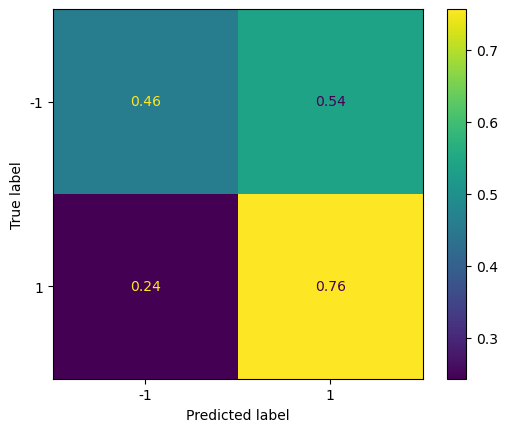

In [86]:
ConfusionMatrixDisplay.from_predictions(y, y_pred, normalize="true")
plt.show()

In [79]:
y

array([-1, -1,  1, ...,  1, -1, -1])

In [80]:
y_pred

array([-1, -1,  1, ..., -1,  1,  1])

In [83]:
fp = (y == -1) & (y_pred == 1)
fp

array([False, False, False, ..., False,  True,  True])

In [90]:
sum(fp)

621

In [92]:
feature_df_FP = feature_df[fp]

In [106]:
feature_df_FP.columns

Index(['id', 'length', 'hydr_count', 'polar_count', 'molecular_weight',
       'helix', 'turn', 'sheet', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K',
       'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', 'fasta_sequence',
       'thsa_netsurfp2', 'tasa_netsurfp2', 'rhsa_netsurfp2', 'disorder',
       'A_exposed', 'C_exposed', 'D_exposed', 'E_exposed', 'F_exposed',
       'G_exposed', 'H_exposed', 'I_exposed', 'K_exposed', 'L_exposed',
       'M_exposed', 'N_exposed', 'P_exposed', 'Q_exposed', 'R_exposed',
       'S_exposed', 'T_exposed', 'V_exposed', 'W_exposed', 'Y_exposed',
       'Prob. of Solubility', 'Aggregation_propensity', 'Aromaticity',
       'Instability_index', 'Gravy', 'isoelectric_point', 'charge_at_7',
       'charge_at_5', 'HSP', 'PTM_UP', 'Citrullination_UP', 'GPI-anchor_UP',
       'Lipoprotein_UP', 'Nitration_UP', 'Prenylation_UP', 'ISGylation_UP',
       'NEDDylation_UP', 'Acetylation_all', 'Glycosylation_all',
       'Methylation_all', 'Myristoylation_all',

In [108]:
feat = "Glycosylation_all"

print("Predicted as CSF but annotated as negative:", feature_df_FP[feat].mean())
print("All brain proteins:", feature_df[feat].mean())
print("All CSF positive brain proteins:", feature_df[feature_df["CSF"] == 1][feat].mean())

Predicted as CSF but annotated as negative: 0.15619967793880837
All brain proteins: 0.34409638554216865
All CSF positive brain proteins: 0.521551724137931


In [78]:
from sklearn.decomposition import PCA
import plotly.express as px
from sklearn.preprocessing import StandardScaler

features_continuous = ['length', 'hydr_count', 'polar_count', 'molecular_weight', 'helix', 'turn', 'sheet', 'A', 'C', 'D', 
                       'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', 'thsa_netsurfp2',
                       'tasa_netsurfp2', 'rhsa_netsurfp2', 'disorder', 'A_exposed', 'C_exposed', 'D_exposed', 'E_exposed', 
                       'F_exposed', 'G_exposed', 'H_exposed', 'I_exposed', 'K_exposed', 'L_exposed', 'M_exposed', 'N_exposed', 
                       'P_exposed', 'Q_exposed', 'R_exposed', 'S_exposed', 'T_exposed', 'V_exposed', 'W_exposed', 'Y_exposed',
                       'Prob. of Solubility', 'Aggregation_propensity', 'Aromaticity', 'Instability_index', 'Gravy', 
                       'isoelectric_point', 'charge_at_7', 'charge_at_5', 'Polar_exposed', 'Hydrophobic_exposed']

# scale data before PCA
df_pca = feature_df.drop(["id", "fasta_sequence"], axis=1)
df_pca[features_continuous] = pd.DataFrame(StandardScaler().fit_transform(df_pca[features_continuous]))

pca = PCA(n_components=2)
components = pca.fit_transform(df_pca)

# plot first two principal components
fig = px.scatter(components, x=0, y=1, color=df_pca["CSF"])
fig.show()